In [45]:
import scanpy as sc
import anndata as an
import pandas as pd
import stereo as st
import numpy as np

In [4]:
mouse_data_path = '/goofys/Samples/MOSTA/E12.5/E12.5_E1S1.MOSTA.h5ad'
adata = an.read(mouse_data_path)

In [14]:
data = st.io.read_ann_h5ad(file_path=mouse_data_path, spatial_key='spatial')

In [16]:
data.tl.normalize_total(target_sum=10000)
data.tl.log1p()

[2023-03-27 11:39:09][Stereo][53916][139731479356352][st_pipeline][32][INFO]: start to run normalize_total...
[2023-03-27 11:39:10][Stereo][53916][139731479356352][st_pipeline][35][INFO]: normalize_total end, consume time 1.8173s.
[2023-03-27 11:39:10][Stereo][53916][139731479356352][st_pipeline][32][INFO]: start to run log1p...
[2023-03-27 11:39:13][Stereo][53916][139731479356352][st_pipeline][35][INFO]: log1p end, consume time 2.9119s.


In [70]:
from stereo.core.stereo_exp_data import StereoExpData
from anndata import AnnData
from typing import Optional
def anndata_to_stereo(andata: AnnData, use_raw=False, spatial_key: Optional[str] = None):
    """
    transform the Anndata object into StereoExpData object.

    :param andata: input Anndata object,
    :param use_raw: use andata.raw.X if True else andata.X. Default is False.
    :param spatial_key: use .obsm[`'spatial_key'`] as position.
    :return: StereoExpData obj.
    """
    # data matrix,including X,raw,layer
    data = StereoExpData()
    data.exp_matrix = andata.raw.X if use_raw else andata.X
    # obs -> cell
    data.cells.cell_name = np.array(andata.obs_names)
    data.cells.n_genes_by_counts = andata.obs[
        'n_genes_by_counts'] if 'n_genes_by_counts' in andata.obs.columns.tolist() else None
    data.cells.total_counts = andata.obs['total_counts'] if 'total_counts' in andata.obs.columns.tolist() else None
    data.cells.pct_counts_mt = andata.obs['pct_counts_mt'] if 'pct_counts_mt' in andata.obs.columns.tolist() else None
    # var
    data.genes.gene_name = np.array(andata.var_names)
    data.genes.n_cells = andata.var['n_cells'] if 'n_cells' in andata.var.columns.tolist() else None
    data.genes.n_counts = andata.var['n_counts'] if 'n_counts' in andata.var.columns.tolist() else None
    # position
    data.position = andata.obsm[spatial_key] if spatial_key is not None else None
    data.result = pd.DataFrame()
    data.result['annotation'] = andata.obs['annotation']
    data.key_record = pd.DataFrame()
    data.key_record['annotation'] = andata.obs['annotation']
    # self.reset_key_record('annotation', 'annotation')
    return data

data2 = anndata_to_stereo(adata)

In [71]:
data2.tl.find_marker_genes(cluster_res_key='annotation', use_highly_genes=False, use_raw=False)


[2023-03-27 12:55:39][Stereo][53916][139731479356352][st_pipeline][32][INFO]: start to run find_marker_genes...


Exception: annotation is not in the result, please check and run the func of cluster.

In [69]:
data2.key_record

{'annotation': cell_name
 100_124    Cavity
 100_125    Cavity
 100_126     Brain
 100_127     Brain
 100_128     Brain
             ...  
 99_272     Cavity
 99_273     Cavity
 99_274     Cavity
 99_275     Cavity
 99_276     Cavity
 Name: annotation, Length: 51365, dtype: category
 Categories (23, object): ['Blood vessel', 'Brain', 'Cartilage primordium', 'Cavity', ..., 'Ovary', 'Pancreas', 'Sympathetic nerve', 'Urogenital ridge']}

In [5]:
# https://www.gene-quantification.de/willems-et-al-ref-2006.pdf
housekeeping_genes1 = ['Tbp', 'Actb', 'Ubc', 'Gapdh', 'B2m', 'Pgk1', 'Ldha'] # 'G6pd',  '18S' Hprt1
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4181407/ (Table 1)
housekeeping_genes2 = ['H2afz', 'Sdha', 'Tgfb1', 'Gapdh', 'Actb', 'Sptbn', 'Ablim', 'Ywhaz', 'Wrnip', '18s']
housekeeping_genes = set(housekeeping_genes1 + housekeeping_genes2)
housekeeping_genes = [gene for gene in housekeeping_genes if gene in adata.var.index ]
housekeeping_genes

['Ldha',
 'Ywhaz',
 'Gapdh',
 'B2m',
 'Ubc',
 'Pgk1',
 'Tgfb1',
 'Actb',
 'H2afz',
 'Sdha',
 'Tbp']

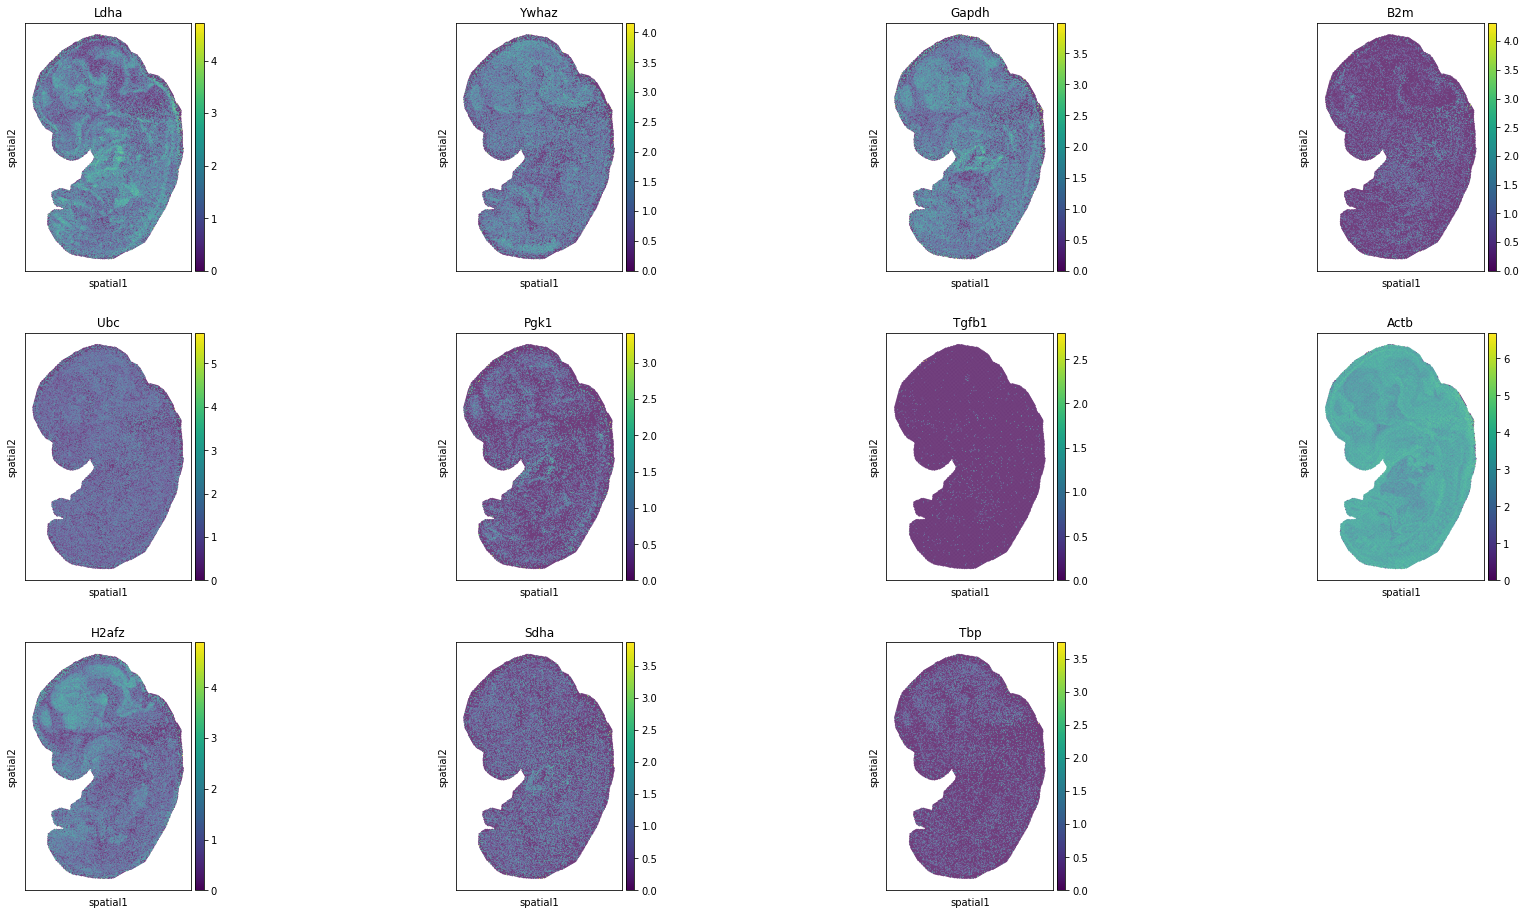

In [6]:
sc.pl.spatial(adata, color = housekeeping_genes, spot_size=1.2)

In [7]:
sc.pp.highly_variable_genes(adata)
hvgs = adata.var[adata.var['highly_variable']].index

In [8]:
for gene in housekeeping_genes:
    if gene not in adata.var.index:
        print(f'Not in {gene}')
    if gene in hvgs:
        print(f'{gene} is HVG!')

In [9]:
sc.tl.rank_genes_groups(adata, 'annotation', method='wilcoxon', pts=True)

/home/ubuntu/anaconda3/envs/st/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/ubuntu/anaconda3/envs/st/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/ubuntu/anaconda3/envs/st/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: Da

In [10]:
sc.get.rank_genes_groups_df(adata, ann, pval_cutoff=0.05)

NameError: name 'ann' is not defined

In [ ]:
all_marker_df = pd.DataFrame()
for ann in set(adata.obs['annotation']):
    print(ann)
    marker_df = sc.get.rank_genes_groups_df(adata, ann, pval_cutoff=0.05)#.loc[:,'names'].values) for name in adata.uns['rank_genes_groups']['names'].dtype.names}
    marker_df.loc[:, 'pts_fold'] = marker_df['pct_nz_group'] / marker_df['pct_nz_reference'] 
    marker_df[marker_df['pts_fold'] > 3]
    all_marker_df = pd.concat([all_marker_df, marker_df])
all_marker_df
            #  pd.DataFrame(adata.uns['rank_genes_groups'])

Sympathetic nerve
Kidney
Lung primordium
Epidermis
GI tract
Cartilage primordium
Muscle
Liver
Blood vessel
Cavity
Mucosal epithelium
Brain
Mesothelium
Heart
Meninges
Dorsal root ganglion
Choroid plexus
Pancreas
Mesentery
Urogenital ridge
Jaw and tooth
Connective tissue
Ovary


,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,pts_fold
0,Nefm,21.754589,4.925871,6.250324e-105,1.738215e-100,0.978378,0.233001,4.199028
1,Nefl,21.231369,4.619959,4.901447e-100,6.815462e-96,0.972973,0.214224,4.541842
2,Gap43,19.798737,3.709858,3.052539e-87,2.829704e-83,0.983784,0.339898,2.894347
3,Cartpt,18.627144,5.484629,1.935818e-77,1.345878e-73,0.827027,0.061254,13.501513
4,Oraov1,18.297596,2.872089,8.648104e-75,4.810076e-71,0.945946,0.450957,2.097639
...,...,...,...,...,...,...,...,...
1899,Sox11,-13.867262,-1.719209,1.000224e-43,5.454164e-41,0.525994,0.760806,0.691364
1900,Stmn1,-14.312449,-1.216951,1.829550e-46,1.156359e-43,0.868502,0.922881,0.941076
1901,Tmsb4x,-16.091667,-0.975973,2.918715e-58,2.387337e-55,1.000000,0.994063,1.005972
1902,Nnat,-18.292440,-1.857485,9.506385e-75,1.258917e-71,0.700306,0.897410,0.780363


In [ ]:
len(set(all_marker_df['names']))

NameError: name 'all_marker_df' is not defined